# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Summary](#summary)


<a id='intro'></a>
### Introduction

For this project, we're working to understand the results of an A/B test run by an e-commerce website. The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

In [1]:
# Importing the required the libraries

import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
%matplotlib inline

# Setting the seed to assure you get the same answers on quizzes
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# Finding the shape of the dataframe (row, columns)
print(df.shape)
print('Number of rows =', df.shape[0])

(294478, 5)
Number of rows = 294478


c. The number of unique users in the dataset.

In [4]:
# Checking for unique values in the user_id column
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# Selecting rows where this condition is True (treatment and new_page not matching), then displaing the shape (rows, columns)
df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page'))].shape[0]

3893

f. Do any of the rows have missing values?

In [7]:
# Checking for any NaN values in the dataframe
df.isnull().sum().sum()

0

><span style="color:red">No missing values included</span><br><br>

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Dropping rows where the provious condition is True, using conditional indexing, saving the output to a new dataframe df2
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [9]:
# Udacity - Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
# Checking for unique values in the user_id column
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
# checking for duplicated in the user_id column
df2[df2.duplicated(['user_id'])]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
# Dropping duplicated rows in place
df2.drop_duplicates('user_id', inplace = True)

In [14]:
# Checking for duplicates
sum(df2.duplicated('user_id'))

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
all_conversion_rate = df2.converted.mean()
all_conversion_rate

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
old_conversion_rate = df2[df2['group'] == "control"].converted.mean()
old_conversion_rate

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
new_conversion_rate = df2[df2['group'] == "treatment"].converted.mean()
new_conversion_rate

0.11880806551510564

_Calculating the actual difference in conversion rate in the original data_

In [18]:
actual_diff = new_conversion_rate - old_conversion_rate
actual_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [19]:
df2[df2['landing_page'] == "new_page"].shape[0]/df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>**<span style="color:red">Answer</span><br><br>**
>**There is no sufficient statistical evidence to conclude that the new treatment page leads to more conversions as the change in average conversion probability is very small in value. It actually decreased by 0.16%:
><br><br><li>Control group who received the old page conversion probability = 12.04%
><br><li>Treatment group who received the new page conversion probability = 11.88%**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

>**Since we assume that the old page is better unless the new page proves to be definitely better, the null hypothesis should be that converted rate for the new page is less than or equal to the converted rate for the old page, and the alternative would suggest that the converted rate for the new page is higher.**
>
>$$H_0: p_{new} \leq p_{old}  $$
>
>$$H_1: p_{new} > p_{old} $$
>
>or 
>
>$$H_0: p_{new} - p_{old} \leq 0$$
>
>
>$$H_1: p_{new} - p_{old} > 0$$
>
>
>where
><br>
>$p_{new}$ and $p_{old}$ are the converted rates values for new and old pages, respectivley.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = all_conversion_rate
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br>

In [21]:
p_old = all_conversion_rate
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2[df2['group'] == "treatment"].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2[df2['group'] == "control"].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1, p=p_new, size=n_new)
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, p=p_old, size=n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean() - old_page_converted.mean()

0.00090628730610582686

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
# Simulation through Binomial Distribution -- Edited for obtimization
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

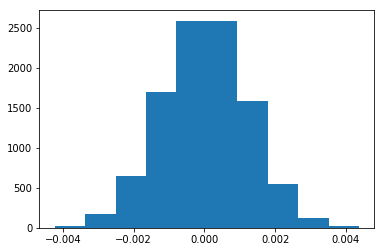

In [28]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

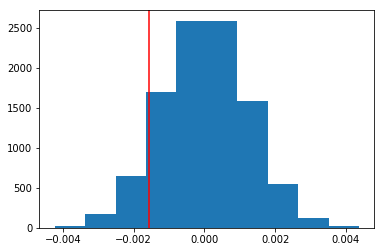

In [29]:
# Plotting a histogram of p_diffs highlighting the actual difference in the original dataset
plt.hist(p_diffs);
plt.axvline(x=actual_diff, color='red');

In [30]:
# The proportion of the p_diffs greater than the actual difference
## Converting the p_diffs list to a numpy array to avoid errors
(np.array(p_diffs) > actual_diff).mean()

0.90510000000000002

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>**<span style="color:red">Answer</span><br><br>**
>**This value is called the p-value, and can be described here as the proportion of the p-diffs values that are larger than the actual difference.<br><br>**
>**This large p-value of 0.91 suggests that;**
><li>Our statistic was likely to come from the Null
><li>We shouldn't move away from the Null Hypothesis,
><li>The difference between the new and old pages is truly less than 0
><li>We should stay with the old page.    
<br>

>_**In summary, the calculated p-value of 0.91 suggests that we do not have evidence to reject the Null Hypothesis**_

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
convert_old = df2[df2['converted'] == 1].query('landing_page == "old_page"').shape[0]
convert_new = df2[df2['converted'] == 1].query('landing_page == "new_page"').shape[0]
n_old = df2[df2['landing_page'] == "old_page"].shape[0]
n_new = df2[df2['landing_page'] == "new_page"].shape[0]

In [32]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [33]:
stat, pval = proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')

print('p-value = {0:0.3f}'.format(pval))
print('z-score = {0:0.3f}'.format(stat))

p-value = 0.905
z-score = -1.311


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>**<span style="color:red">Answer</span>**
>
>The p-value and the negative z-score computed here corresponds with the one obtained by the sampling distribution<br>
>
>_**Again, we do not have evidence to reject the Null Hypothesis**_

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>**<span style="color:red">Answer</span>**
>
>**Logistic Regression**<br>
>to bound the response to a probability between _0 and 1 (no conversion and conversion)_

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
Logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = Logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-15 16:22 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

>**<span style="color:red">Answer</span>**
>
>**The null and alternative hypotheses associated with a regression model are set to test the null hypothesis that the variable coefficient is equal to zero (no effect), meaning that this explanatory variable has no effect on the response, and the alternative being not equal to zero. This is a two-sided t-test compared to a one-sided t-test in part II.**
>
>**Result:**
><li>The resulting p-value associated with ab_page here equals 0.1899
><li>The set alpha level (type I error) for the A/B test is 0.05
><li>p-value > alpha, which means that it is not statistically significant.

>_**This concludes that we failed to reject this null hypothesis, and that it is actually true that the explanatory variable (landing page) has low effect on the response variable (conversion)**_

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**<span style="color:red">Answer</span>**
>
>**As concluded from the previous models, the available data cannot aim in predicting the response variable, so we should consider exploring other factors and how they are related to the response.**<br><br>
>**The disadvantages to adding additional terms into the model include the possibility of having Multicollinearity, when the predictor variables are correlated with one another, but this can be identified in many ways.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
df_countries.shape

(290584, 2)

In [39]:
df_countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
df2 = df2.merge(df_countries, on = 'user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [41]:
df2 = df2.join(pd.get_dummies(df2['country']))

In [42]:
df2.sample(10)

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
282428,743539,2017-01-03 20:17:13.357718,treatment,new_page,1,1,1,US,0,0,1
97723,704742,2017-01-08 23:37:15.315977,treatment,new_page,0,1,1,US,0,0,1
51599,889711,2017-01-11 00:24:07.779597,treatment,new_page,1,1,1,US,0,0,1
262888,665138,2017-01-08 18:12:08.678890,treatment,new_page,0,1,1,US,0,0,1
122737,930893,2017-01-24 06:07:40.840537,treatment,new_page,0,1,1,US,0,0,1
134611,835439,2017-01-23 08:43:20.642618,control,old_page,0,0,1,UK,0,1,0
138709,703910,2017-01-16 09:26:59.072906,treatment,new_page,0,1,1,UK,0,1,0
109364,870353,2017-01-12 05:03:53.791839,treatment,new_page,0,1,1,US,0,0,1
70546,753843,2017-01-17 14:46:58.434047,treatment,new_page,0,1,1,US,0,0,1
253939,783530,2017-01-12 03:13:42.402943,control,old_page,0,0,1,US,0,0,1


In [43]:
Logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']])
results = Logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-15 16:22 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [44]:
np.exp(-0.0149), np.exp(-0.0408), np.exp(0.0099)

(0.9852104557227469, 0.96002111497165088, 1.0099491671175422)

In [45]:
1/np.exp(-0.0149), 1/np.exp(-0.0408)

(1.0150115583846535, 1.0416437559600236)

>**<span style="color:red">Answer</span>**
>
>**It does not appear that the country has an impact on conversion as the p-values associated with all the explanatory variables are higher than the set alpha level, which indicates that they are not statistically significant.**<br>
>
>**The exponentiation of the coefficients also indicate that changes in the country or the page does not practically impact the likelihood of conversion**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
df2['CA_new'] = df2['CA'] * df2['ab_page']
df2['UK_new'] = df2['UK'] * df2['ab_page']
df2.sample(10)

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US,CA_new,UK_new
144291,723574,2017-01-21 05:04:20.065742,treatment,new_page,0,1,1,UK,0,1,0,0,1
15114,780603,2017-01-10 20:48:14.432072,treatment,new_page,0,1,1,US,0,0,1,0,0
44069,892898,2017-01-06 21:13:09.685465,control,old_page,0,0,1,US,0,0,1,0,0
229196,880634,2017-01-22 05:25:16.462510,control,old_page,0,0,1,US,0,0,1,0,0
152103,921204,2017-01-04 18:43:55.183732,control,old_page,0,0,1,US,0,0,1,0,0
277752,695024,2017-01-21 08:55:45.316474,control,old_page,0,0,1,US,0,0,1,0,0
131772,881349,2017-01-05 23:29:22.536435,treatment,new_page,0,1,1,US,0,0,1,0,0
16007,823566,2017-01-05 21:53:48.778195,control,old_page,0,0,1,UK,0,1,0,0,0
85342,656615,2017-01-07 15:29:41.558038,control,old_page,0,0,1,US,0,0,1,0,0
103510,895779,2017-01-05 13:38:27.263577,treatment,new_page,1,1,1,US,0,0,1,0,0


In [47]:
Logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK', 'CA_new', 'UK_new']])
results = Logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-07-15 16:22 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_new       -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_new        0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

>**<span style="color:red">Answer</span>**
>
>**The p-values indicate that there is no multicollinearity between the variables, or the landing page is not dependent on the country. This was expected as the coefficients (slopes) of these variables in the previous Logistic Regression model are close enough to equal**<br><br>
>_**Which in turn means that there is no need to add an interaction**_

<a id='summary'></a>
## Summary

### The analysis done using three different approaches;

><li> Descriptive Statistics & Probability
><li> A/B Testing through Sampling Distributions & Hypothesis Testing
><li> Logistic Regression Modelling


### The findings can be summarized as following;

>**Probability:**
The change in average conversion probability is very small in value. It actually decreased by 0.16%
    
>**Hypothesis Testing:**
Null Hypothesis set that the new page is not better than the old page.
The resulting p-value equals 0.906, which mean that we do not have evidence to reject the Null Hypothesis

>**Logistic Regression**
The regression model indicates that it is actually true that the explanatory variable (landing page) has low effect on the response variable (conversion)

### Conclusion
>**<li>There is no sufficient statistical evidence to conclude that the new treatment page leads to more conversions**
>**<li>We failed to reject the Null Hypothesis**
>**<li>The company should not run the new page**

In [48]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0